# Imports Libraries and Tools

In [1]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [6]:
# Directories for training and testing data
train_dir = 'Training'
test_dir = 'Testing'

#train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

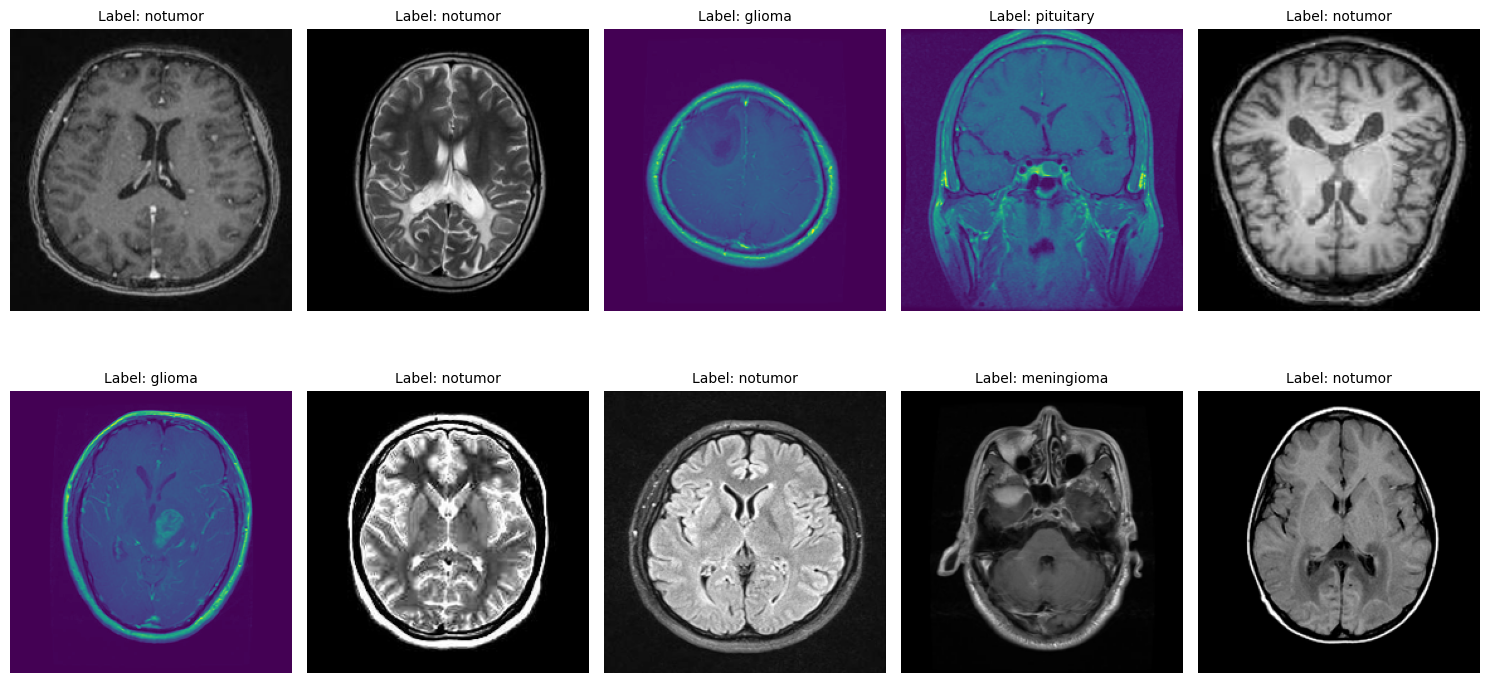

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os


random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [12]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) 
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:

## WE ARE USING ResNet50 FOR TRANSFER LEARNING.

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

# Image size (adjust based on your requirements)
IMAGE_SIZE = 128

# Load ResNet50 as base model, without the top fully connected layers (for transfer learning)
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the ResNet50 base model to be trainable
base_model.layers[-2].trainable = True  # Example: fine-tuning the second-to-last layer
base_model.layers[-3].trainable = True  # Example: fine-tuning the third-to-last layer
base_model.layers[-4].trainable = True  # Example: fine-tuning the fourth-to-last layer

# Build the final model with the base ResNet50 model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add the pre-trained ResNet50 base model
model.add(Flatten())  # Flatten the output from the convolutional base
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters for training
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - loss: 0.8538 - sparse_categorical_accuracy: 0.7525
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 0.2118 - sparse_categorical_accuracy: 0.9174
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9462
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9719
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9790


# Train and Val Plots

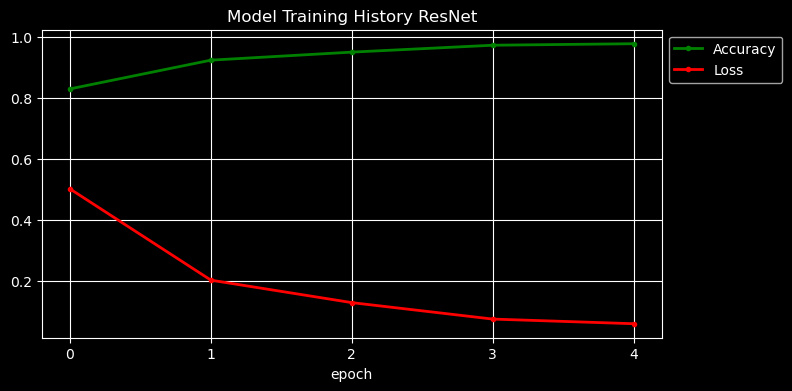

In [46]:
plt.style.use('dark_background')
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History ResNet')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       262
           1       0.89      0.94      0.92       306
           2       0.99      1.00      1.00       405
           3       0.98      0.96      0.97       300

    accuracy                           0.96      1273
   macro avg       0.96      0.95      0.95      1273
weighted avg       0.96      0.96      0.96      1273



# Model Confusion Plot

Confusion Matrix:
[[239  22   0   1]
 [ 10 289   3   4]
 [  0   1 404   0]
 [  1  12   0 287]]


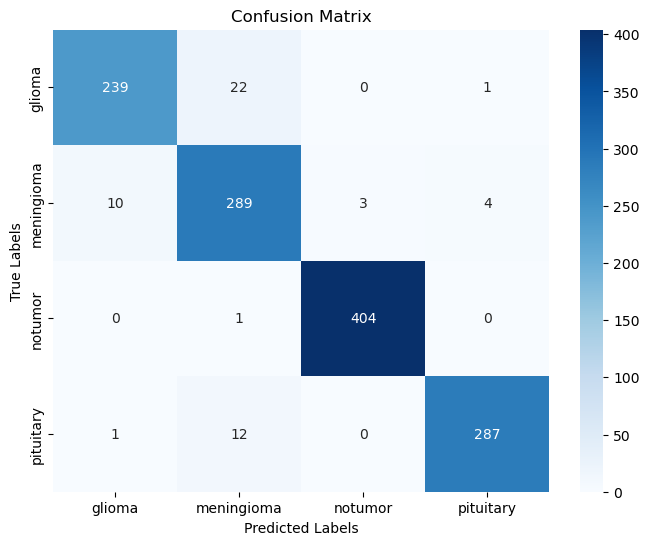

In [23]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save & Load Model

In [30]:
# Save the entire model
model.save('model_resnet50.h5')

In [48]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model_resnet50.h5')

# Implementing Gradio

In [50]:
import gradio as gr

In [51]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import gradio as gr
from tensorflow.keras.models import load_model

# Load model
model = load_model("model.h5")

# Class labels
labels = ['glioms', 'meningioma', 'notumor', 'pituitar']

def predict_tumor(image):
    # Convert to array
    image = cv2.resize(image, (128, 128))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Predict
    preds = model.predict(image)[0]

    # Build result dict
    result = {label: round(float(prob), 3) for label, prob in zip(labels, preds)}
    return result


In [ ]:
interface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=4),
    title="Brain Tumor Classifier Using ResNet50",
    description="Upload a brain scan image to classify tumor type."
)

interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://3ea16f00800f485574.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
